In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

In [2]:
filename = 'D:\\Sandbox\\Github\\Data\\Frozen_Dessert_Production.csv'

In [3]:
df = pd.read_csv(filename, index_col='DATE', parse_dates=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [5]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [6]:
df.columns = ['Production']

In [7]:
df.tail()

,Production
DATE,
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632
2019-08-01,102.6085
2019-09-01,101.5866


<AxesSubplot:xlabel='DATE'>

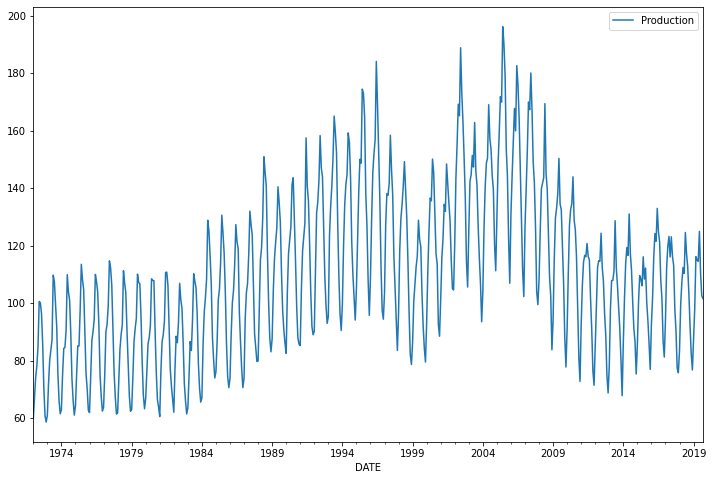

In [8]:
df.plot(figsize=(12,8))

In [9]:
len(df)

573

In [10]:
test_size = 24
test_ind = len(df)- test_size

In [11]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [12]:
len(test)

24

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAINING DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler()

In [16]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
length = 18
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [20]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [22]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
early_stop = EarlyStopping(monitor='val_loss',patience=50)

In [25]:
# fit model
model.fit(generator,epochs=100,
          validation_data=validation_generator,
          callbacks=[early_stop])

Epoch 1/10
531/531 [==============================] - 4s 7ms/step - loss: 0.0307 - val_loss: 0.0047
Epoch 2/10
531/531 [==============================] - 3s 6ms/step - loss: 0.0164 - val_loss: 0.0127
Epoch 3/10
531/531 [==============================] - 3s 6ms/step - loss: 0.0060 - val_loss: 0.0023
Epoch 4/10
531/531 [==============================] - 3s 6ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 5/10
531/531 [==============================] - 4s 7ms/step - loss: 0.0030 - val_loss: 0.0066
Epoch 6/10
531/531 [==============================] - 4s 7ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 7/10
531/531 [==============================] - 4s 7ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 8/10
531/531 [==============================] - 3s 6ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 9/10
531/531 [==============================] - 3s 5ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 10/10
531/531 [==============================] - 3s 6ms/step - loss: 0.0028 - val_loss: 0.0023

<AxesSubplot:>

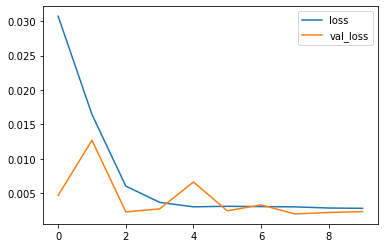

In [26]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [27]:
train_predictions = []

first_step = scaled_train[-length:]
current_step = first_step.reshape((1, length, n_features))

for i in range(len(train)):
    current_pred = model.predict(current_step)[0]
    train_predictions.append(current_pred) 
    current_step = np.append(current_step[:,1:,:], [[current_pred]], axis=1)

In [28]:
test_predictions = []

test_first_step = scaled_test[-length:]
test_current_step = test_first_step.reshape((1, length, n_features))

for i in range(len(test)):
    test_current_pred = model.predict(test_current_step)[0]
    test_predictions.append(test_current_pred) 
    test_current_step = np.append(test_current_step[:,1:,:], [[test_current_pred]], axis=1)

In [29]:
true_test_predictions = scaler.inverse_transform(test_predictions)

In [30]:
true_train_predictions = scaler.inverse_transform(train_predictions)

In [31]:
len(true_test_predictions)

24

In [32]:
len(true_train_predictions)

549

In [33]:
train.loc[:,'Predictions'] = true_train_predictions

C:\Users\Amir\anaconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Amir\anaconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [34]:
train.head(4)

,Production,Predictions
DATE,,
1972-01-01,59.9622,88.722425
1972-02-01,67.0605,80.166518
1972-03-01,74.2350,78.369302
1972-04-01,78.1120,84.277166


In [35]:
# test['Predictions'] = true_test_predictions

In [36]:
test.loc[:,'Predictions'] = true_test_predictions

C:\Users\Amir\anaconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Amir\anaconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [37]:
test.head(4)

,Production,Predictions
DATE,,
2017-10-01,90.4732,87.943722
2017-11-01,77.4378,79.025898
2017-12-01,75.8118,75.951141
2018-01-01,83.4343,81.128585


<AxesSubplot:xlabel='DATE'>

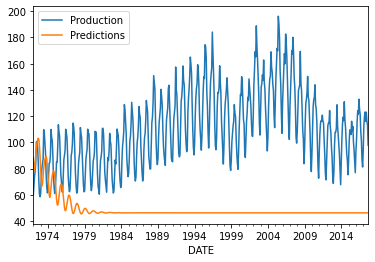

In [38]:
train.plot()

<AxesSubplot:xlabel='DATE'>

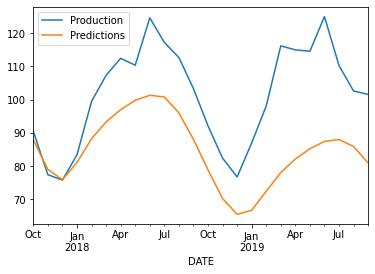

In [39]:
test.plot()

In [40]:
from sklearn.metrics import mean_squared_error

In [41]:
np.sqrt(mean_squared_error(train['Production'],train['Predictions']))

69.10447935380563

In [42]:
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

19.9084968533618

In [57]:
future_predictions = []

test_first_step = scaled_test[-length:]
test_current_step = test_first_step.reshape((1, length, n_features))
no_months = 12
# predict next 12 months 
for i in range(no_months):
    test_current_pred = model.predict(test_current_step)[0]
    future_predictions.append(test_current_pred) 
    test_current_step = np.append(test_current_step[:,1:,:], [[test_current_pred]], axis=1)

In [58]:
len(future_predictions)

12

In [59]:
true_future_predictions = scaler.inverse_transform(future_predictions)

In [60]:
dates = pd.date_range('9/1/2019', periods=no_months, freq='M')

In [61]:
dates

DatetimeIndex(['2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31'],
              dtype='datetime64[ns]', freq='M')

In [62]:
df_future = pd.DataFrame(data=true_future_predictions, columns=['Future'],           
                         index=dates )

In [63]:
df_future

,Future
2019-09-30,87.943722
2019-10-31,79.025898
2019-11-30,75.951141
2019-12-31,81.128585
2020-01-31,88.246606
2020-02-29,93.319955
2020-03-31,96.997996
2020-04-30,99.807541
2020-05-31,101.322883
2020-06-30,100.813915


In [64]:
df_future = df_future.rename(columns = {'index':'DATE'})

In [65]:
df_future

,Future
2019-09-30,87.943722
2019-10-31,79.025898
2019-11-30,75.951141
2019-12-31,81.128585
2020-01-31,88.246606
2020-02-29,93.319955
2020-03-31,96.997996
2020-04-30,99.807541
2020-05-31,101.322883
2020-06-30,100.813915


<AxesSubplot:>

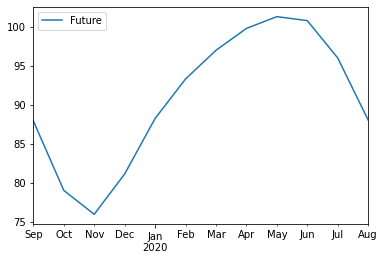

In [66]:
df_future.plot()

<AxesSubplot:xlabel='DATE'>

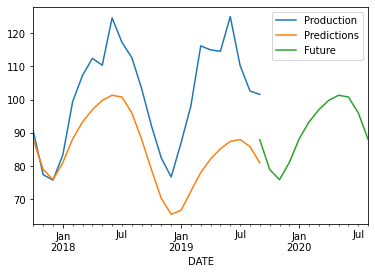

In [68]:
ax = test.plot(label='test')
df_future.plot(ax=ax)

<AxesSubplot:xlabel='DATE'>

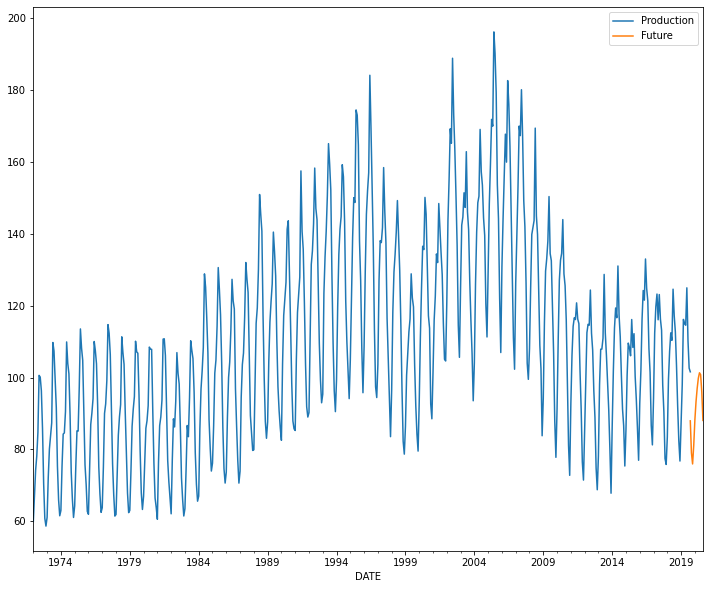

In [67]:
ax = df.plot(figsize=(12,10),label='df')
df_future.plot(ax=ax)